## Crude Oil

### Weekly

Epoch 1/70


C:\Users\dipes\AppData\Local\Temp\ipykernel_22452\1410392829.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


80/80 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0027
Epoch 2/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 3/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 4/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 5/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 6/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 7/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 8/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 9/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/70
80/80 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 11/70
80/80 [===========

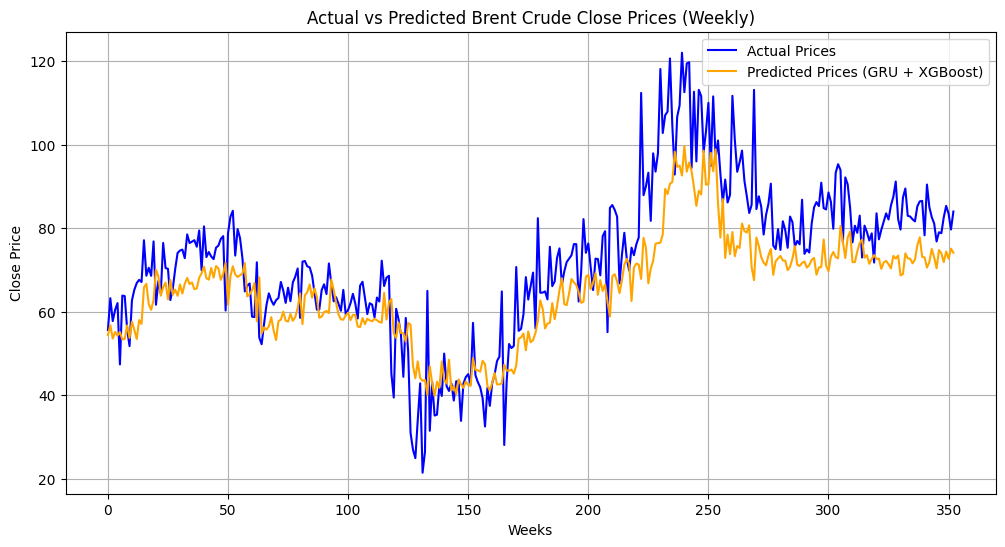

1/1 [==============================] - 0s 17ms/step

 Brent Crude Oil - Future Weekly Predictions :
        Date  Predicted Close Price
0 2024-09-08              74.127220
1 2024-09-15              73.898743
2 2024-09-22              71.448997
3 2024-09-29              72.334854
4 2024-10-06              70.251434


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Load weekly dataset
data = pd.read_csv('brent_crude_oil_atr_ema_rsi_w2.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Define features and target
features = [
    'Open', 'High', 'Low', 'Vol.', 'ATR', 'EMA_12', 'EMA_26', 'RSI',
    'S&P500_Close', 'S&P500_ATR', 'S&P500_EMA_12', 'S&P500_EMA_26', 'S&P500_RSI',
    'CBOE_Close', 'CBOE_ATR', 'CBOE_EMA_12', 'CBOE_EMA_26', 'CBOE_RSI',
    'USDI_Close', 'USDI_ATR', 'USDI_EMA_12', 'USDI_EMA_26', 'USDI_RSI'
]
target = 'Close'

# Normalize features and target
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Create time sequences
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(scaled_df.values, time_steps)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build GRU model with EarlyStopping
gru_model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train GRU
gru_model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# GRU predictions for XGBoost input
gru_train_pred = gru_model.predict(X_train)
gru_test_pred = gru_model.predict(X_test)

# Prepare data for XGBoost
X_train_xgb = np.hstack([X_train.reshape(X_train.shape[0], -1), gru_train_pred])
X_test_xgb = np.hstack([X_test.reshape(X_test.shape[0], -1), gru_test_pred])

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.06, max_depth=5, random_state=42)
xgb_model.fit(X_train_xgb, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_test_xgb)

# Rescale predictions and ground truth
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
xgb_preds_inv = scaler_target.inverse_transform(xgb_preds.reshape(-1, 1))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_inv, xgb_preds_inv))
accuracy = 100 - np.mean(np.abs((y_test_inv - xgb_preds_inv) / y_test_inv)) * 100

print(f"\n RMSE: {rmse:.2f}")
print(f" Accuracy: {accuracy:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(xgb_preds_inv, label='Predicted Prices (GRU + XGBoost)', color='orange')
plt.title('Actual vs Predicted Brent Crude Close Prices (Weekly)')
plt.xlabel('Weeks')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Future Prediction
future_weeks = 5
last_sequence = X_test[-1]  # Last known sequence
future_preds = []

for _ in range(future_weeks):
    # GRU predicts based on sequence
    gru_out = gru_model.predict(last_sequence[np.newaxis, :, :])
    xgb_input = np.append(last_sequence.reshape(-1), gru_out).reshape(1, -1)
    
    # XGBoost predicts next week
    next_pred_scaled = xgb_model.predict(xgb_input)
    next_pred_actual = scaler_target.inverse_transform(next_pred_scaled.reshape(-1, 1))[0][0]
    future_preds.append(next_pred_actual)
    
    # Create next sequence by dropping first week and appending new prediction
    new_week = last_sequence[-1].copy()  # Reuse last week's features (simplified)
    last_sequence = np.append(last_sequence[1:], [new_week], axis=0)

# Dates for future predictions
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start='2024-09-08', periods=future_weeks, freq='W-SUN')

# Output future predictions
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close Price': future_preds
})
print("\n Brent Crude Oil - Future Weekly Predictions :")
print(future_df)


### Monthly 

Epoch 1/70
18/18 [==============================] - 1s 11ms/step - loss: 0.0871 - val_loss: 0.0285
Epoch 2/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0049
Epoch 3/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 4/70
18/18 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 5/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 6/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 7/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 8/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/70
18/18 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 11/70
18/18 

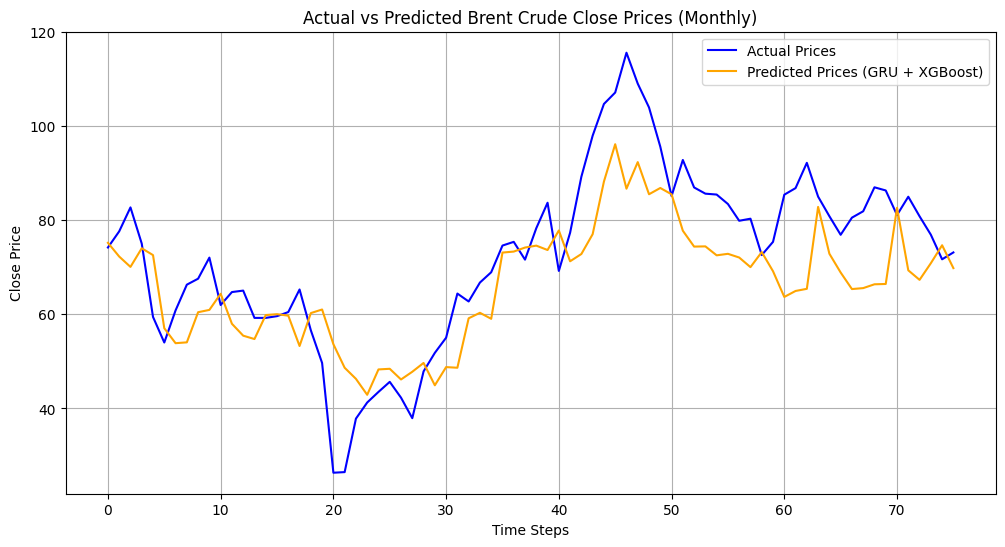

1/1 [==============================] - 0s 17ms/step

 Monthly Brent Crude Predictions (Starting Nov 1, 2024):
        Date  Predicted Close Price
0 2024-11-01              69.826767
1 2024-12-01              74.436523
2 2025-01-01              73.771133
3 2025-02-01              73.575455
4 2025-03-01              73.993942


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Load monthly Brent Crude dataset
data = pd.read_csv('brent_crude_oil_atr_ema_rsi_m2.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Define features and target
features = [
    'Open', 'High', 'Low', 'Vol.', 'ATR', 'EMA_10', 'EMA_20', 'RSI',
    's&p_500_Close', 's&p_500_ATR', 's&p_500_EMA_12', 's&p_500_EMA_26', 's&p_500_RSI',
    'cboe_Close', 'cboe_ATR', 'cboe_EMA_12', 'cboe_EMA_26', 'cboe_RSI',
    'usdi_Close', 'usdi_ATR', 'usdi_EMA_12', 'usdi_EMA_26', 'usdi_RSI'
]
target = 'Close'

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Create sequences
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12  # 12 months history
X, y = create_sequences(scaled_df.values, time_steps)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build GRU model
gru_model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

gru_model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# GRU outputs for XGBoost
gru_train_pred = gru_model.predict(X_train)
gru_test_pred = gru_model.predict(X_test)

X_train_xgb = np.hstack([X_train.reshape(X_train.shape[0], -1), gru_train_pred])
X_test_xgb = np.hstack([X_test.reshape(X_test.shape[0], -1), gru_test_pred])

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.085, max_depth=5, random_state=42)
xgb_model.fit(X_train_xgb, y_train)

# Predict and inverse scale
xgb_preds = xgb_model.predict(X_test_xgb)
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])

y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
xgb_preds_inv = scaler_target.inverse_transform(xgb_preds.reshape(-1, 1))

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_inv, xgb_preds_inv))
accuracy = 100 - np.mean(np.abs((y_test_inv - xgb_preds_inv) / y_test_inv)) * 100

print(f"\n RMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(xgb_preds_inv, label='Predicted Prices (GRU + XGBoost)', color='orange')
plt.title('Actual vs Predicted Brent Crude Close Prices (Monthly)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Forecast Future Prices 
future_months = 5
last_seq = X_test[-1]
future_predictions = []

for _ in range(future_months):
    gru_out = gru_model.predict(last_seq[np.newaxis, :, :])
    xgb_input = np.append(last_seq.reshape(-1), gru_out).reshape(1, -1)
    next_pred_scaled = xgb_model.predict(xgb_input)
    next_pred_actual = scaler_target.inverse_transform(next_pred_scaled.reshape(-1, 1))[0][0]
    future_predictions.append(next_pred_actual)

    # Update sequence: simplified assumption
    next_features = last_seq[-1].copy()  # reuse last month's features
    last_seq = np.append(last_seq[1:], [next_features], axis=0)

# Create future dates (starting Nov 1, 2024)
future_dates = pd.date_range(start='2024-11-01', periods=future_months, freq='MS')

# Output
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close Price': future_predictions
})

print("\n Monthly Brent Crude Predictions (Starting Nov 1, 2024):")
print(future_df)
